In [3]:
from itertools import product
import os, shutil, math
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, rankdata
from sklearn import metrics
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
# global settings for figures
sns.set(context="paper", style="white", font_scale=1)

In [3]:
# define functions for code generation

def vec2str(vec):
    return ''.join([chr(ord('A')+i) for i in vec])

def read_fasta(dir):
    file = open(dir, 'r')
    names = []
    vecs = []
    for line in file.readlines():
        if '#' in line or len(line)<=1:
            continue
        if '>' in line:
            names.append(line.strip('> \n'))
        else:
            vec = [v for v in line.strip(' \n').split(',') if v]
            try:
                vec = [float(s) for s in vec]
            except ValueError:
                vec = [ord(s) for s in vec]
                vec = ''.join([chr(ord('A')+i) for i in vec])
            vecs.append(vec)
    # seqs = {name: vec for name,vec in zip(names,vecs)}
    # return seqs
    return names, vecs

def dense_dists(d):
    num_seqs = d[:,1].max() + 1
    dist = np.zeros((num_seqs, num_seqs))
    for i in range(d.shape[0]):
        dist[d[i,0],d[i,1]] = d[i,2]
    dist = dist + dist.transpose()
    return dist

def dict_configs(d):
    for k,v in d.items():
        if isinstance(v,list):
            pass
        elif isinstance(v,range):
            d[k] = list(v)
        else:
            d[k] = [v]
    for vcomb in product(*d.values()):
        yield dict(zip(d.keys(), vcomb))

def conf2str(conf, multiline):
    if multiline:
        eol = '\n'
    else:
        eol = ' '
    str = ''
    for k,v in conf.items():
        str += '--{}={}{}'.format(k,v,eol)
    return str

def grid_flagfiles(grid, dir_name):
    for ci, config in enumerate(dict_configs(grid)):
        config['o'] = config['o'] + str(ci) + '/'
        outfile = open('{}/grid_flags_{}'.format(dir_name,ci), 'w')
        if outfile:
            outfile.write(conf2str(config, multiline=True))
        else:
            print('could not open the file')
        outfile.close()

def grid_commands(proj_dir, exec_name, grid, out_dir):
    cmd = 'PROJ_DIR={}\n'.format(proj_dir)
    commands = '{}\necho ">> Project directory ...\\n {}\\n"\n'.format(cmd,cmd)
    proj_dir = '$PROJ_DIR'
    if out_dir.strip()[0] != '/':   # relative output directory
        out_dir = os.path.join(proj_dir, out_dir)
    if exec_name.strip()[0] != '/':
        exec_name = os.path.join(proj_dir, exec_name)
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir)
    for ci, config in enumerate(dict_configs(grid)):
        config['o'] = os.path.join(out_dir, str(ci))
        cmd = '{} {}'.format(exec_name, conf2str(config, multiline=False))
        commands = commands + '\n{}\necho "\\n>> Running Script \\n {}\\n"\n'.format(cmd,cmd)
    outfile = open(os.path.join(out_dir, 'script.sh'), 'w')

    if outfile:
        outfile.write(commands)
    else:
        print('could not open the file')
    outfile.close()


conf_grid = {
    'num_seqs': 1000,
    'alphabet_size': 4,
    'seq_len': 1000,
    'phylogeny_shape': 'path',
    'mutation_type': 'rate',
    'mutation_rate': 1,
    'min_mutation_rate': 0,
    'block_mutation_rate': 0.0,
    'kmer_size': [1,4,8,12],
    'tuple_length': range(2,6),
    'stride': [50,100],
    'window_size': [100,200,500],
    'embed_dim': 30,
    'group_size': 2,
    'hash_alg': 'crc32',
    'num_threads': 0,
}
bin_name = 'experiments'
experiment_dir = '/tmp/test3'
bin_path = '/home/amir/CLionProjects/Project2020-seq-tensor-sketching/cmake-build-release'

# grid_flagfiles(grid=conf_grid, dir_name=experiment_dir)
grid_commands(proj_dir=bin_path, exec_name=bin_name, grid=conf_grid, out_dir=experiment_dir)

In [10]:
def get_summary(path, thresh):
    flags = pd.read_csv(os.path.join(path, 'flags'), delimiter='=', header=None, names=['name', 'value'])
    flags = {row['name'].strip('-'): row['value'] for _,row in flags.iterrows()}
    flags['pairs'] = float(flags['num_seqs'])/float(flags['group_size'])
    flags['pairs'] = str(int(flags['pairs']))
    seq_len = float(flags['seq_len'])

    dists = pd.read_csv(os.path.join(path, 'dists.csv'))
    columns = [l for l in dists.columns]
    methods = columns[3:8]
    methods.append(columns[2]) # put ED at the end

    times = pd.read_csv(os.path.join(path, 'timing.csv'), skipinitialspace=True)
    times = {row['short name'] : row['time'] for _,row in times.iterrows() }
    # timesRel = {k : (v/times['ED']) for k,v in times.items()}
    timesAbs = [times[m] for m in methods]
    timesRel = [times[m]/times['ED'] for m in methods]


    AUC = [[] for _ in thresh]
    for thi,th in enumerate(thresh):
        for m in methods:
            fpr, tpr, thresholds = metrics.roc_curve(dists['ED']<th * seq_len, dists[m], pos_label=0)
            AUC[thi].append(metrics.auc(fpr, tpr))

    SpCorr = []
    for m in methods:
        sr = spearmanr(dists['ED'], dists[m]).correlation
        if math.isnan(sr): # nan occurs if one vector contains a single value, set to 0
            sr = 0
        SpCorr.append(sr)

    summary = {'method' : methods, 'Sp' : SpCorr, 'AUC0' : AUC[0], 'AUC1': AUC[1], 'AUC2': AUC[2], 'AbsTime': timesAbs, 'RelTime': timesRel}
    return flags, dists, summary

def texify_table(flags, summary, thresh):
    # best Sp corr, AUC values (higher better), exclude edit distance
    best_row = {k : np.argmax(v[:-1]) for k, v in summary.items()}
    # best times (lower better), excluce edit distance
    best_row['AbsTime'] = np.argmin(summary['AbsTime'][:-1])
    best_row['RelTime'] = np.argmin(summary['RelTime'][:-1])
    for name,col in summary.items():
        if name=='method':
            continue
        for i,v in enumerate(col):
            v= '{:.3f}'.format(v)
            if best_row[name]==i:
                summary[name][i] = '\\textbf{' + v + '}'
            else:
                summary[name][i] = v

    table_body = 'Method  & Spearman  & {} & Abs. ($10^{{-3}}$ sec) & Rel.(1/ED) \\\\\n\hline\n'.format(' & '.join(str(th) for th in thresh))
    table_body = table_body + '\\\\\n\hline\n'.join([' & '.join(col[row] for method, col in summary.items()) for row in range(6) ] )

    caption = """
\caption{{${flags[pairs]}$ sequence pairs of length $\SLen={flags[seq_len]}$
were generated over an alphabet of size $\#\Abc={flags[alphabet_size]}$.
with the number of random edit operations, uniformly drawn from $\{{0,1,\dots,\SLen\}}$.
The time column shows normalized time in microseconds, i.e., total time divided by number of sequences,
while the relative time shows the ratio of sketch-based time to the time for computing exact edit distance.
As for the the model parameters, embedding dimension is set to $\EDim={flags[embed_dim]}$, and model parameters are
(a) MinHash $k = {flags[kmer_size]}$,
(b) Weighted MinHash $k={flags[kmer_size]}$,
(c) Ordered MinHash $k=3,t=3$,
(d) Tensor Sketch $t=3$,
(e) Tensor Slide Sketch $w={flags[window_size]},t={flags[tuple_length]}$.}}
    """
    caption = caption.format(flags=flags)


    table_latex = """
\begin{table}[h!]
    """ + caption + """
\centering
\begin{tabular}{ |c|c|c|c|c|c|c|}
\hline
\multicolumn{1}{|c|}{\textbf{}} &
\multicolumn{1}{|c|}{\textbf{Correlation}} &
\multicolumn{"""+str(len(thresh))+"""}{|c|}{\textbf{AUROC ($\ED \le \cdot $)}} &
\multicolumn{2}{c|}{\textbf{Time}} \\\\
\hline
    """ + table_body + """
\hline
\end{tabular}
\end{table}"""
    fout = open('table.tex','w')
    fout.write(table_latex)
    fout.close()
    return table_latex

def gen_figS1(flags, dists):
    fig, axes = plt.subplots(2,3, figsize = (18, 12))
    cols = dists.columns[3:8]
    for mi,method in enumerate(cols):
        ax = axes[int(mi/3),mi % 3]
        sns.scatterplot(ax=ax,x=dists['ED']/int(flags['seq_len']), y=dists[method]/dists[method].max())
        ax.set_xlabel('Normalized edit dist.')
        ax.set_ylabel('Normalized sketch dist.')
        ax.set_title('({}) {}'.format(chr(ord('a')+mi),method))
        
    fig.delaxes(axes[1][2])
    caption = """
\\caption{{Normalized sketch distance ranks versus normalized edit distance ranks.  
${flags[pairs]}$ sequence pairs of length $\SLen={flags[seq_len]}$ were generated over $\#\Abc={flags[alphabet_size]}$ alphabets. 
One sequence was generated randomly, and the second was mutated, with a mutation rate uniformly drawn 
from $({flags[min_mutation_rate]},{flags[max_mutation_rate]})$, to generate a spectrum of edit distances.  
Subplot (a-e) show the sketch-based distances, normalized by their max value vs. 
edit distances, normalized by the sequence length. 
The embedding dimension for all models, and parameters for each model are $\EDim={flags[embed_dim]}$, 
and parameters models are 
(a) MinHash $k = {flags[kmer_size]}$, 
(b) Weighted MinHash $k={flags[kmer_size]}$, 
(c) Ordered MinHash $k={flags[kmer_size]},t={flags[tuple_length]}$, 
(d) Tensor Sketch $t={flags[tuple_length]}$, 
(e) Tensor Slide Sketch $t={flags[tuple_length]}, w={flags[window_size]}  }}$.
    """
    caption = caption.format(flags=flags)
    plt.savefig('figures/FigS1.pdf')
    fout = open('figures/FigS1.tex','w')
    fout.write(caption)
    fout.close()
    
def gen_figS2(flags, dists, ed_th):
    data = {'fpr': [], 'tpr': [], 'method': [], 'th': []}
    for th in ed_th:
        seq_len = int(flags['seq_len'])
        cols = dists.columns[3:8]
        for mi,method in enumerate(cols):
            fpr, tpr, thresholds = metrics.roc_curve(dists['ED']<th* seq_len, dists[method], pos_label=0)
            data['fpr'].extend(fpr)
            data['tpr'].extend(tpr)
            data['method'].extend([method] * len(fpr))
            data['th'].extend([th] * len(fpr))
    data = pd.DataFrame(data)

    fig, axes = plt.subplots(2,2, figsize = (14,12))
    for thi, th in enumerate(ed_th):
        ax = axes[int(thi/2), thi % 2]
        sns.lineplot(ax=ax, data=data[data.th==th], x='fpr', y='tpr', hue='method')
        ax.set_xlabel('False Positive')
        ax.set_ylabel('True Positive')
        ax.set_title('ROC to detect ED<{}'.format(th))

    caption = """
\caption{{   {flags[pairs]} sequence pairs of length $\SLen={flags[seq_len]}$ were generated over an alphabet of size $\#\Abc={flags[alphabet_size]}$. 
with the mutation rate uniformly drawn from $({flags[min_mutation_rate]},{flags[max_mutation_rate]})$, to produce a range of edit distances. 
Subplots (a)-(e) show the ROC curve for detecting pairs with edit distance (normalized by length) less than ${th[0]},{th[1]},{th[2]},$ and ${th[3]}$respectively 
}}
    """
    caption = caption.format(flags=flags, th=ed_th)
    plt.savefig('figures/FigS2.pdf')
    fout = open('figures/FigS2.tex','w')
    fout.write(caption)
    fout.close()

def gen_fig1(fig1_path):
    ed_th = np.linspace(.05,.5,10)
    flags, dists, summary = get_summary(path=os.path.join(fig1_path, 'AUC'), thresh=[.1,.2,.3])

    data = {'auc': [], 'method': [], 'th': []}
    for th in ed_th:
        seq_len = int(flags['seq_len'])
        cols = dists.columns[3:8]
        for mi,method in enumerate(cols):
            fpr, tpr, thresholds = metrics.roc_curve(dists['ED']<th* seq_len, dists[method], pos_label=0)
            data['auc'].append(metrics.auc(fpr, tpr))
            data['method'].append(method)
            data['th'].append(th)
    stats1 = pd.DataFrame(data)


    dirs = glob(os.path.join(fig1_path, 'seq_len', '*'))
    summaries = pd.DataFrame()
    for path in dirs:
        flags, dists, summary = get_summary(path=path, thresh=[.1,.2,.3])
        summary = pd.DataFrame(summary)
        summary['seq_len'] = int(flags['seq_len'])
        summaries = pd.concat([summaries, pd.DataFrame(summary)])
    stats2 = summaries

    # generate fig 1d
    fig1_path = '/tmp/fig1/'
    dirs = glob(os.path.join(fig1_path, 'embed_dim', '*'))
    summaries = pd.DataFrame()
    for path in dirs:
        flags, dists, summary = get_summary(path=path, thresh=[.1,.2,.3])
        summary = pd.DataFrame(summary)
        summary['embed_dim'] = int(flags['embed_dim'])
        summaries = pd.concat([summaries, pd.DataFrame(summary)])
    stats3 = summaries[summaries.method!='ED']

    fig, axes = plt.subplots(1,4, figsize = (24,6))
    sns.lineplot(ax=axes[0], data=stats1, x='th', y='auc', hue='method')
    axes[0].set_xlabel('ED threshold')
    axes[0].set_ylabel('AUROC')
    axes[0].set_title('(a) AUROC vs. ED threshold'.format(th))
    sns.lineplot(ax=axes[1],data=stats2[stats2.method!='ED'],x='seq_len', y='Sp', hue='method')
    sns.lineplot(ax=axes[2],data=stats2,x='seq_len', y='AbsTime', hue='method')
    sns.lineplot(ax=axes[3],data=stats3,x='embed_dim', y='Sp', hue='method')
    plt.savefig('figures/Fig1.pdf')

def gen_fig2(dists, flags):
    cols = dists.columns[2:8]
    num_seqs = int(flags['num_seqs'])
    d_sq = np.zeros((num_seqs,num_seqs))
    s1 = dists['s1'].astype(int)
    s2 = dists['s2'].astype(int)
    fig, axes = plt.subplots(2,3, figsize = (18,13))
    for mi, method in enumerate(cols):
        d_rank = rankdata(dists[method])
        for i,d in enumerate(d_rank):
            d_sq[s1[i],s2[i]] = d
            d_sq[s2[i],s1[i]] = d
        ax = axes[int(mi/3), mi % 3]
        sns.heatmap(ax=ax, data=d_sq)
        ax.set_xlabel('seq #')
        ax.set_ylabel('seq #')
        ax.set_title('({}) {}'.format(chr(ord('a')+mi),method))
    num_generations = int(math.log2(num_seqs))
    caption = """
\caption{{ 
The subplot (a) illustrate the exact edit distance matrix, 
while the subplots (b)-(f) demonstrate the approximate distance matrices based on sketching methods.
To highlight how well each method preserves the rank of distances, In all plots, the colorcode indicates the rank of each distance (darker, smaller distance).
The phylogeny was simulated by an initial random sequence of lenth $\SLen={flags[seq_len]}$, over an alphabet of size $\#\Abc={flags[alphabet_size]}$. 
Afterwards, for ${num_generations}$ generations, each sequence in the gene pool was mutated and added back to the pool, 
resulting in ${flags[num_seqs]}$ sequences overall. The mutation rate was 
which was mutated drawn uniformly from the interval $({flags[min_mutation_rate]},{flags[max_mutation_rate]})$, to produce a diverse set of distances. 
For all sketching algorithms, embedding dimension is set to $\EDim={flags[embed_dim]}$, 
and individual model parameters are set to
(b) MinHash $k = {flags[kmer_size]}$,
(c) Weighted MinHash $k={flags[kmer_size]}$,
(d) Ordered MinHash $k=3,t=3$,
(e) Tensor Sketch $t=3$,
(f) Tensor Slide Sketch $w={flags[window_size]},t={flags[tuple_length]}$.
}}
    """
    caption = caption.format(flags=flags, num_generations=num_generations)

    plt.savefig('figures/Fig2.pdf')
    fout = open('figures/Fig2.tex','w')
    fout.write(caption)
    fout.close()

/Users/amirjoudaki/software/anaconda/envs/PyTenSketch/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

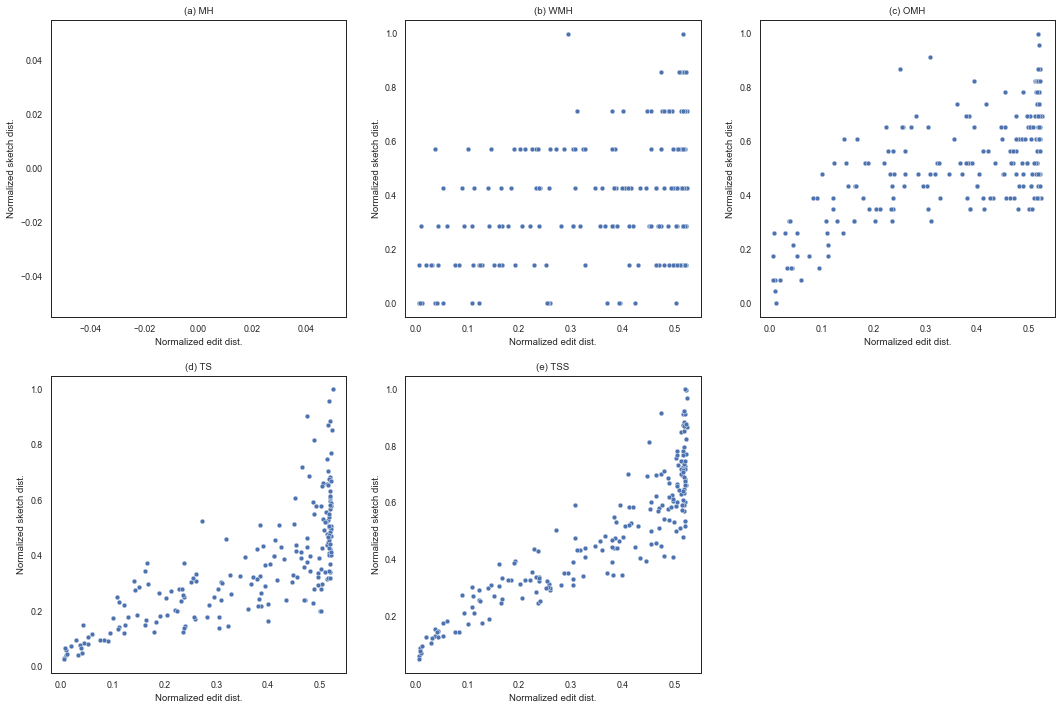

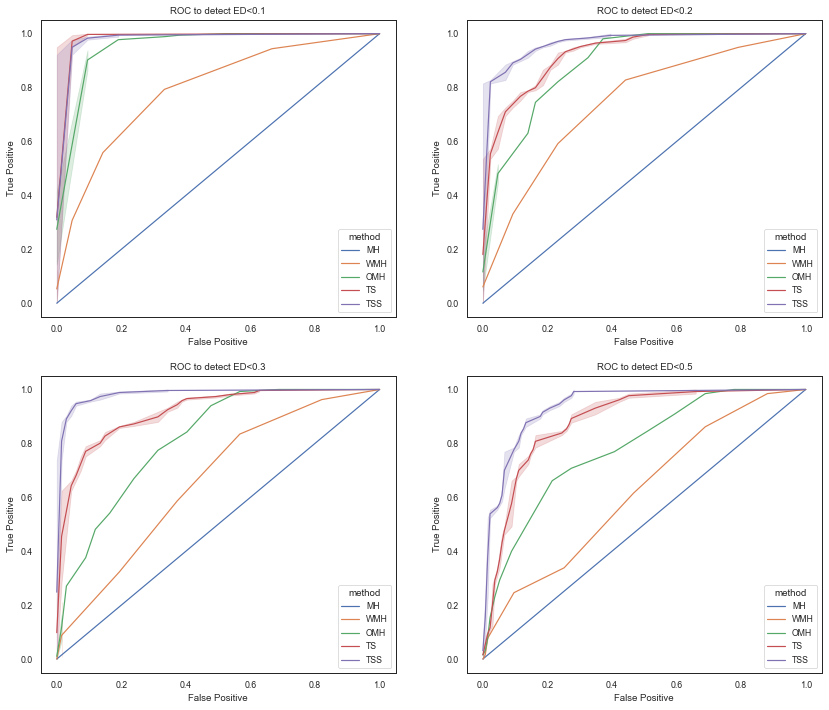

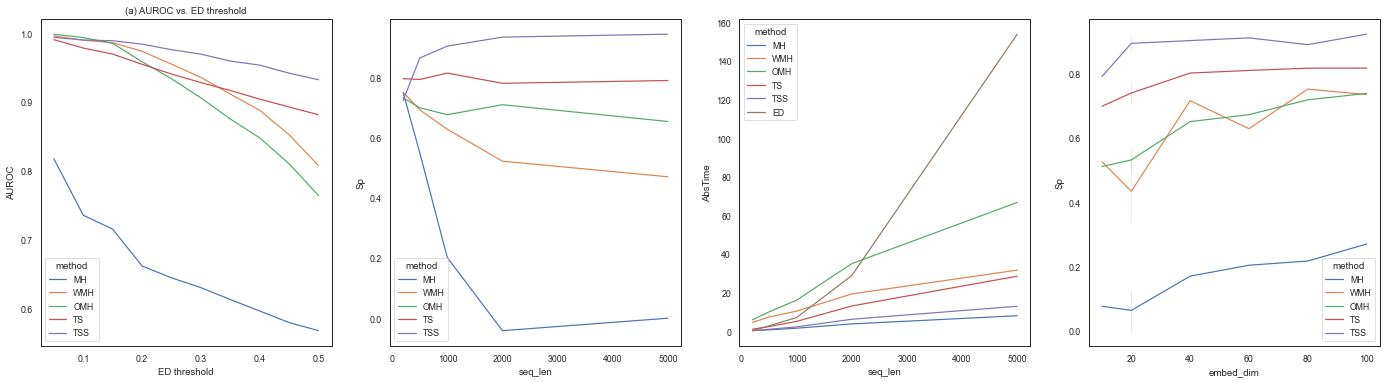

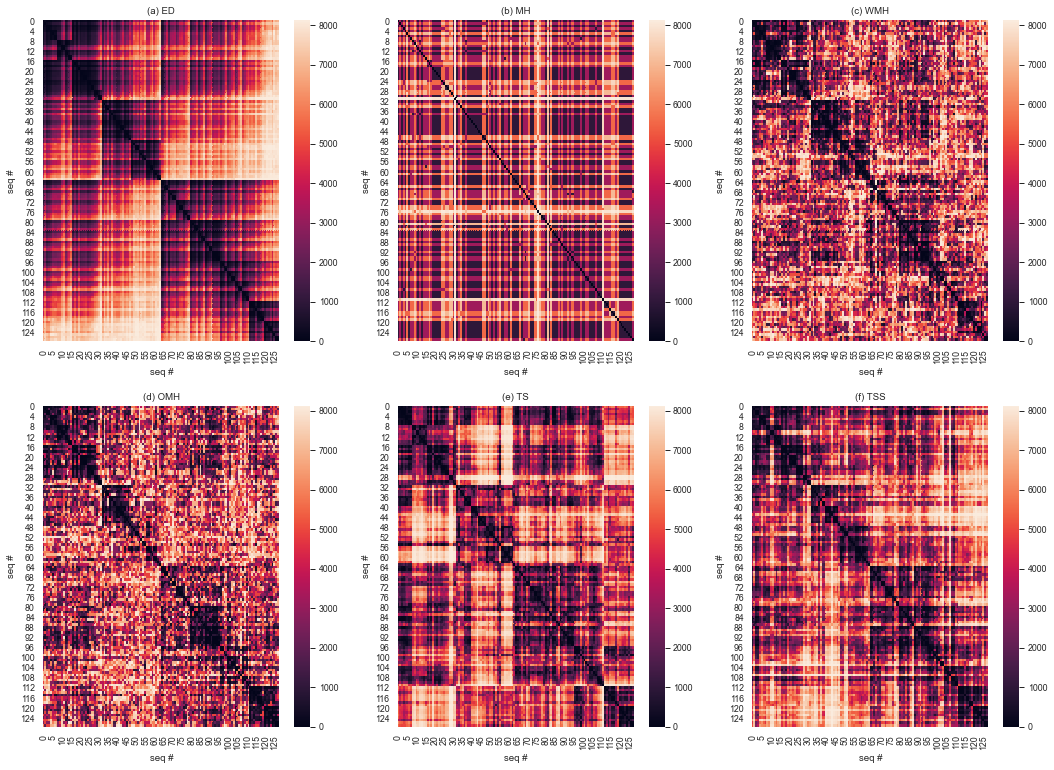

In [9]:
path = '/tmp/table1'
ed_th = [.1, .2, .3, .5]
flags, dists, summary = get_summary(path=path, thresh=ed_th)
table_latex = texify_table(flags=flags, summary=summary, thresh=ed_th)
gen_figS1(flags=flags, dists=dists)
gen_figS2(flags=flags, dists=dists, ed_th=ed_th)

path = '/tmp/fig1/'
gen_fig1(fig1_path=path)

path = '/tmp/fig2'
flags, dists, summary = get_summary(path=path, thresh=ed_th)
gen_fig2(dists=dists, flags=flags)

/Users/amirjoudaki/software/anaconda/envs/PyTenSketch/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

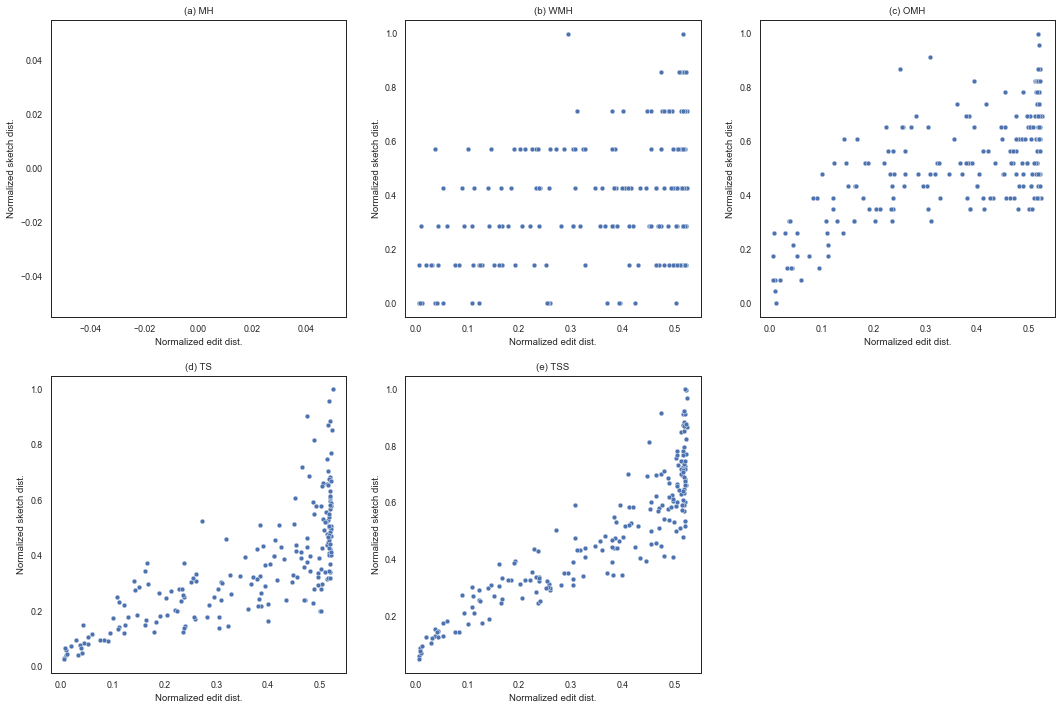

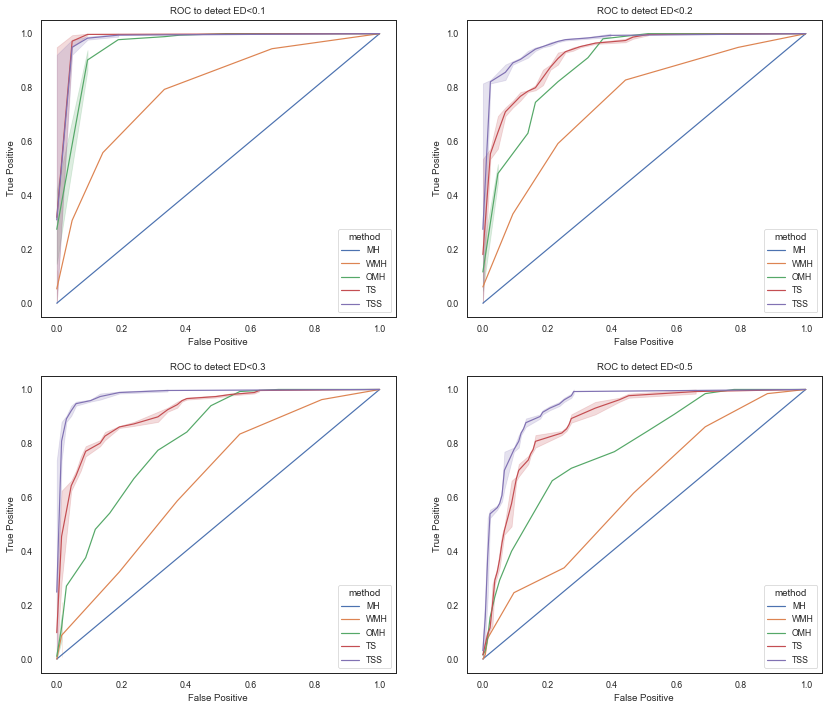

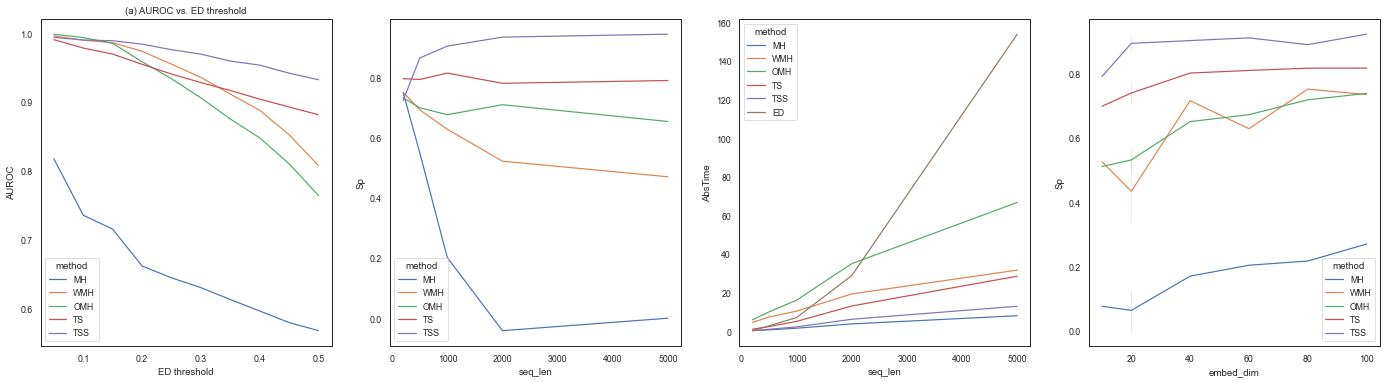

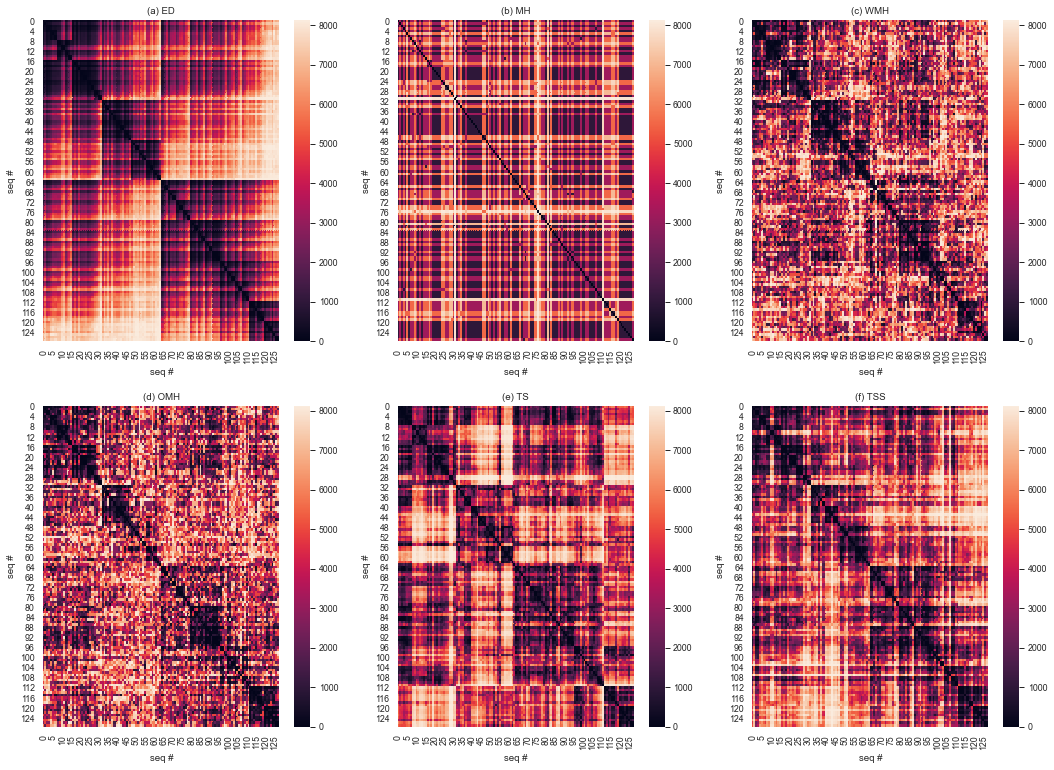

In [17]:
import importlib
import paper_gen as pg
importlib.reload(pg)

path = '/tmp/table1'
ed_th = [.1, .2, .3, .5]
flags, dists, stats = pg.get_summary(path=path, thresh=ed_th)
pg.texify_table(flags=flags, stats=stats, thresh=ed_th)
pg.gen_fig_s1(flags=flags, dists=dists)
pg.gen_fig_s2(flags=flags, dists=dists, ed_th=ed_th)

path = '/tmp/fig1/'
pg.gen_fig1(fig1_path=path)

path = '/tmp/fig2'
pg.gen_fig2(path=path)
